In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
import cv2
import os

from stardist import random_label_cmap, _draw_polygons
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.


# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [2]:
X0 = sorted(glob('../../../../Videos/160930.nd2_PC3_0Gy_p1/train-Perm160930.nd2_PC3_0Gy_p1/images/*.tif'))
X0 = list(map(imread,X0))

n_channel0 = 1 if X0[0].ndim == 2 else X0[0].shape[-1]
axis_norm0 = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel0 > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm4 is None or 2 in axis_norm4 else 'independently'))

In [3]:
X0Mask = sorted(glob('../../../../Videos/160930.nd2_PC3_0Gy_p1/train-Perm160930.nd2_PC3_0Gy_p1/masks/*.tif'))
X0Mask = list(map(imread,X0Mask))

n_channel0 = 1 if X0[0].ndim == 2 else X0[0].shape[-1]
axis_norm0 = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel0 > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm4 is None or 2 in axis_norm4 else 'independently'))

In [2]:
X4 = sorted(glob('../../../../Videos/160930.nd2_PC3_4Gy_p2/C1-160930.nd2_PC3_4Gy_p2/*.tif'))
X4 = list(map(imread,X4))

n_channel4 = 1 if X4[0].ndim == 2 else X4[0].shape[-1]
axis_norm4 = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel4 > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm4 is None or 2 in axis_norm4 else 'independently'))

In [4]:
X8 = sorted(glob('../../../../Videos/8/C1-160930.nd2_PC3_8Gy_p1/*.tif'))
X8 = list(map(imread,X8))

n_channel8 = 1 if X8[0].ndim == 2 else X8[0].shape[-1]
axis_norm8 = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel8 > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm8 is None or 2 in axis_norm8 else 'independently'))

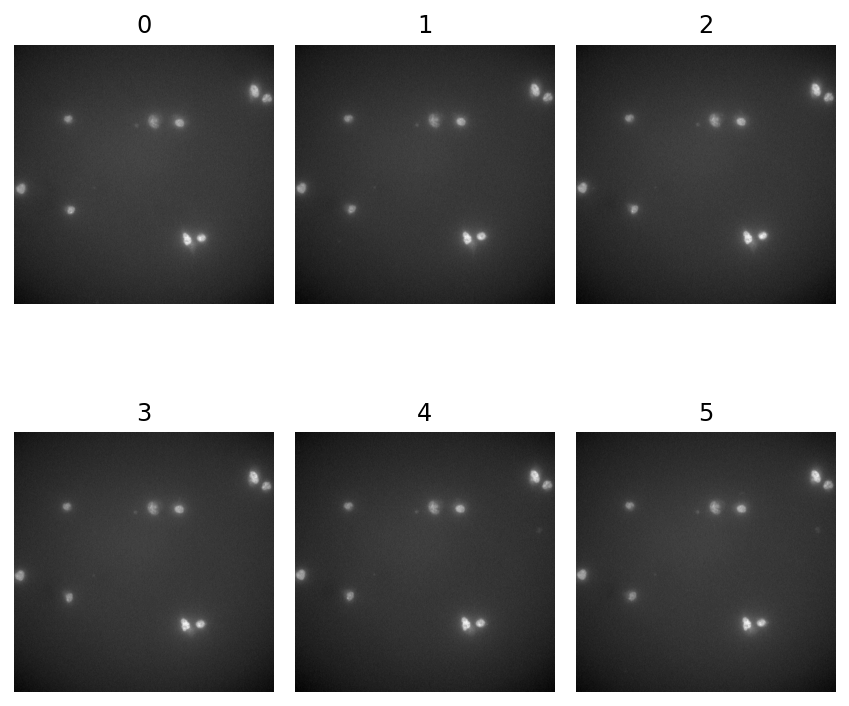

In [3]:
# show all test images
if True:
    fig, ax = plt.subplots(2,3, figsize=(6,6))
    for i,(a,x) in enumerate(zip(ax.flat, X4)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;


In [ ]:

if True:
    fig, ax = plt.subplots(2,3, figsize=(6,6))
    for i,(a,x) in enumerate(zip(ax.flat, X8)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [4]:
demo_model = False

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist2D(None, name='2D_demo', basedir='../../models/examples')
else:
    model = StarDist2D(None, name='stardist', basedir='models')
None;

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.505369, nms_thresh=0.3.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [9]:
img = normalize(X[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

NameError: name 'X' is not defined

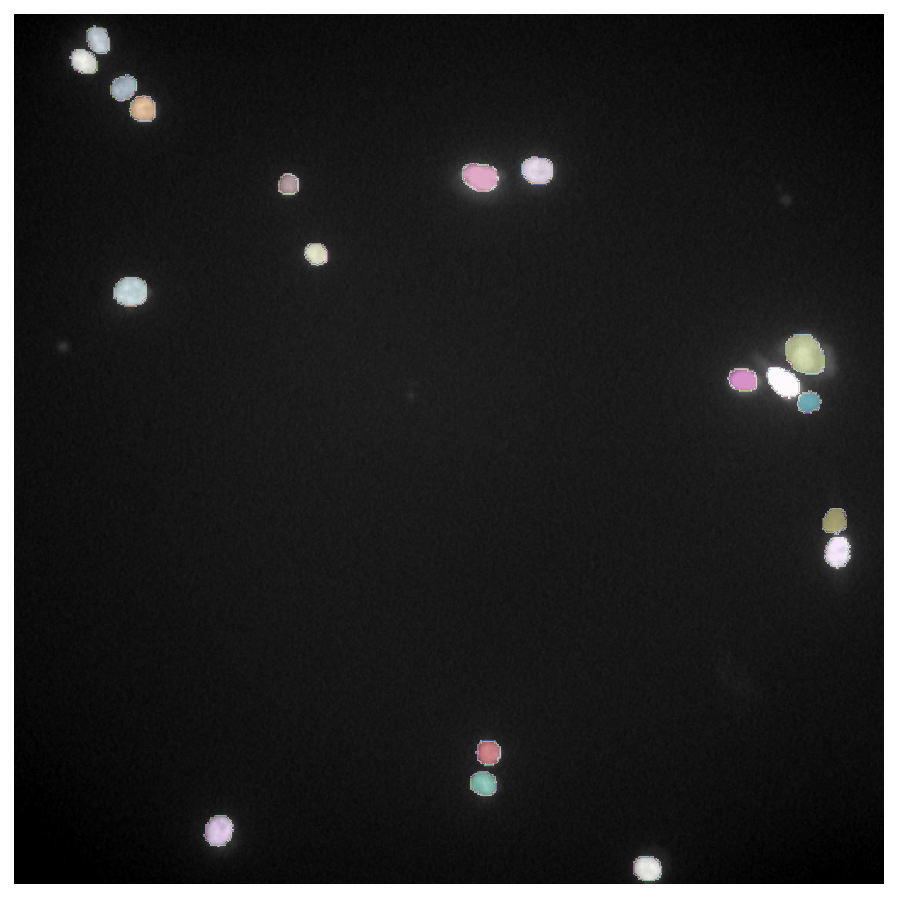

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

# Example results

In [5]:
def example(model, i, show_dist=True):
    img = normalize(X0[i], 1,99.8, axis=axis_norm0)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, grid=model.config.grid, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()
    
def getMask(model, image, axis_norm, show_dist=True):
    img = normalize(image, 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)
    return labels

In [7]:
#Check accuracy
acc=list()

for i in range(len(X0)):
    labels = getMask(model,X0[i],(0,1))
    labels=labels/255
    vectLabel=labels.ravel()
    yVal=X0Mask[i].ravel()
    acc.append(len([yVal for j in range(0, len(yVal)) if yVal[j] == vectLabel[j]]) / len(yVal))
    #example(model,i)
print(acc)

[0.9737701416015625, 0.9735107421875, 0.9948005676269531, 0.9800758361816406, 0.9704513549804688, 0.9658012390136719, 0.9641075134277344, 0.9588165283203125, 0.9666290283203125, 0.9684982299804688]


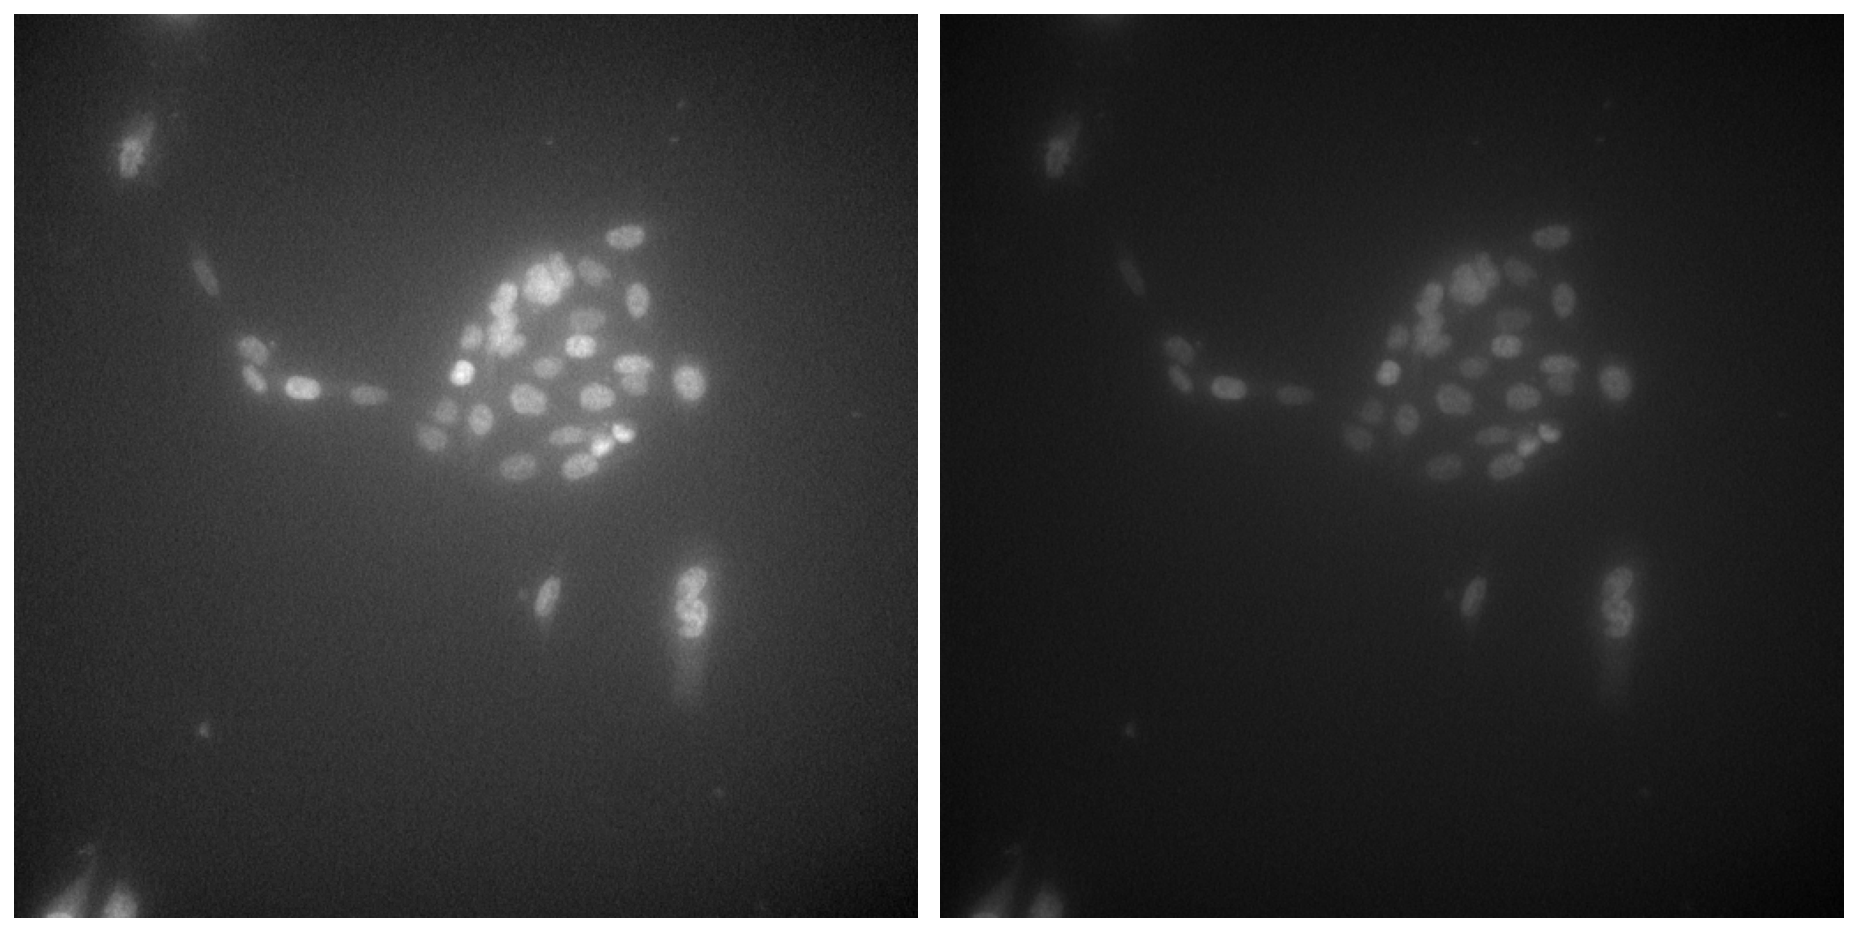

In [25]:
example(model, 1)

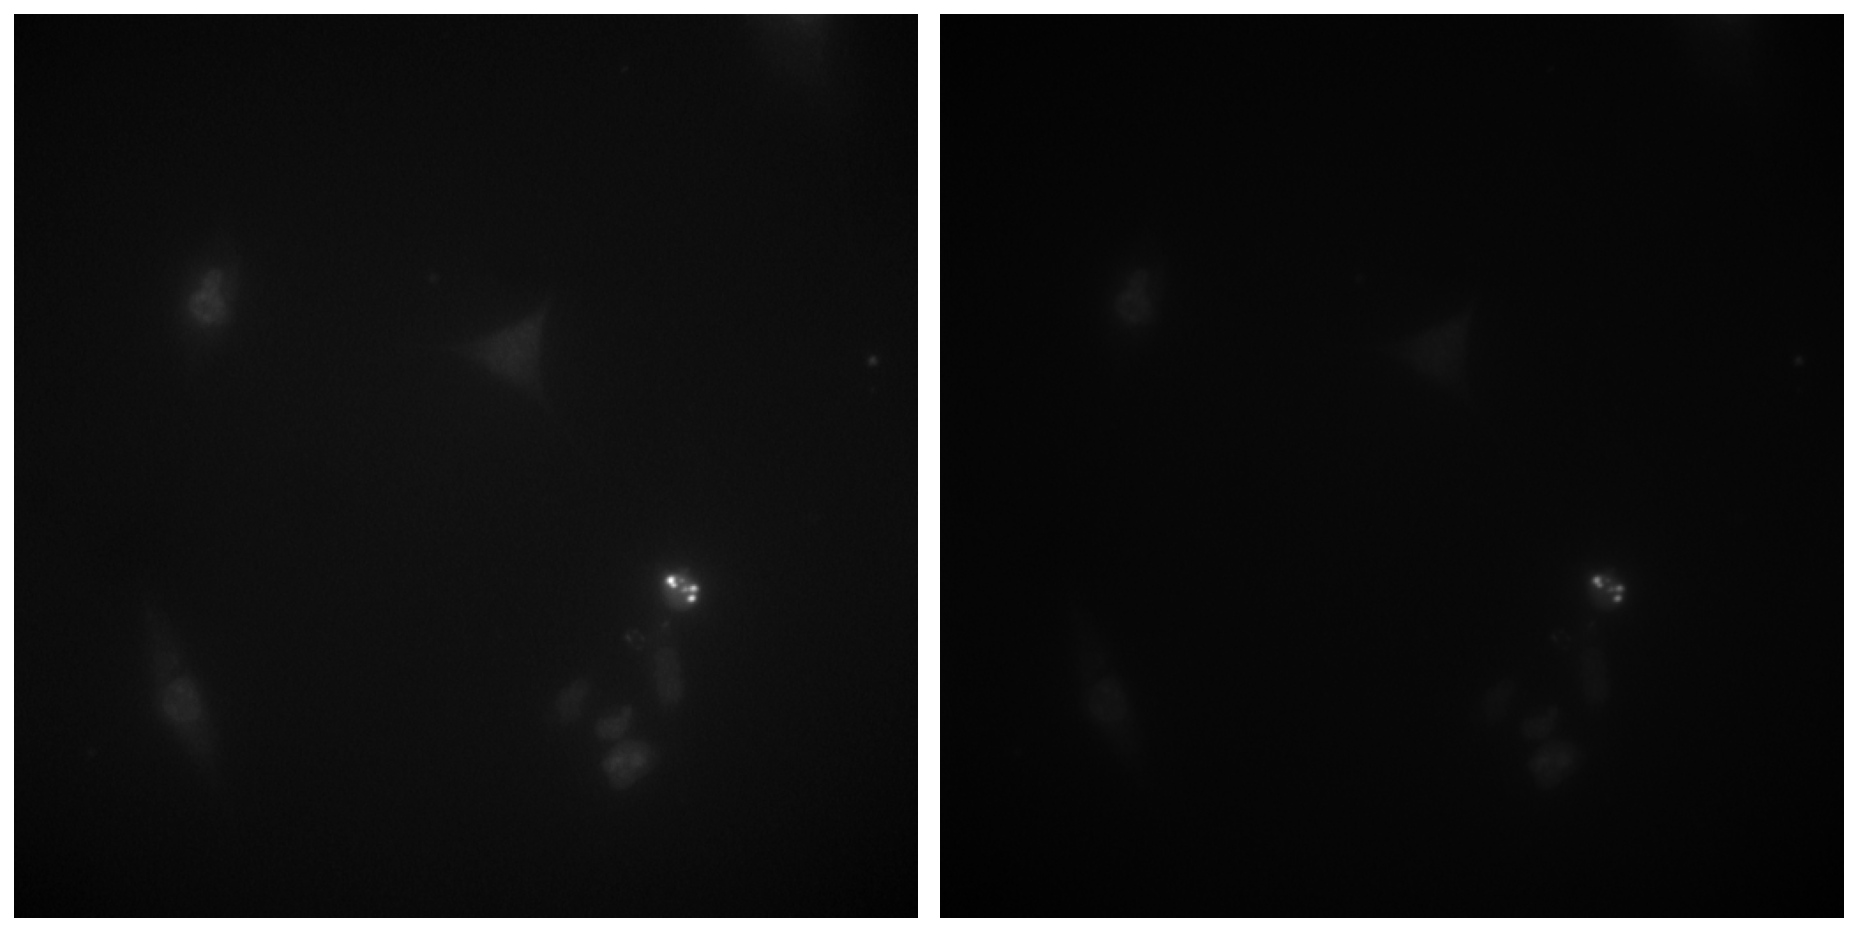

In [12]:
example(model, 662)

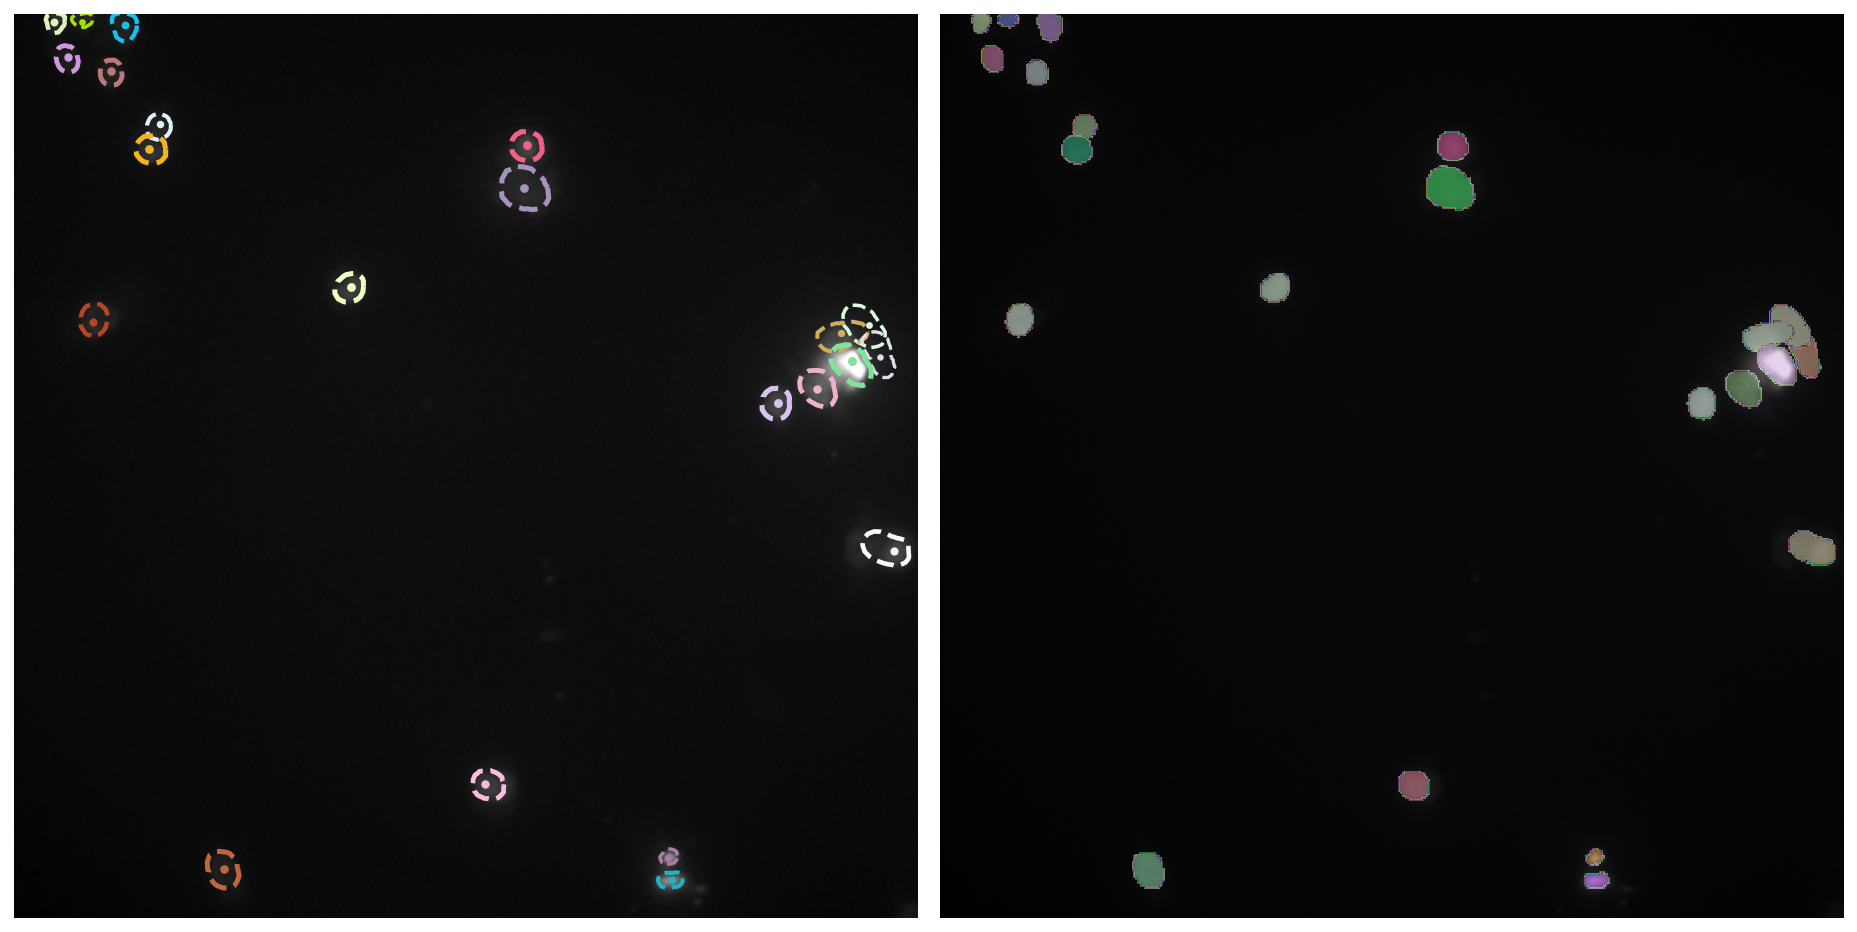

In [20]:
example(model, 200, False)

In [11]:
os.chdir('D:/Archivos/Trabajo/Nantes/Videos/160930.nd2_PC3_0Gy_p3')
for i in [0,1]:
    mask=getMask(model, X0[i],axis_norm0)
    name='Seg_'+str(i)+'.tif'
    cv2.imwrite(name,mask)
    

In [10]:
mask.shape
    

(512, 512)

In [31]:
os.chdir('D:/Archivos/Trabajo/Nantes/Videos')
for i in [0,100,200,300,400,500,600,700]:
    mask=getMask(model, X4[i],axis_norm4)
    name='4/Seg_0-100-200-300-400-500-600-700/'+str(i)+'.tif'
    cv2.imwrite(name,mask)
    
for i in [0,100,200,300,400,500,600,700]:
    mask=getMask(model, X8[i],axis_norm8)
    name='8/Seg_0-100-200-300-400-500-600-700/'+str(i)+'.tif'
    cv2.imwrite(name,mask)
